In [1]:
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
%load_ext autoreload
%autoreload 2
import os
import sys; 
sys.path.extend(['/home/meet/FlowMatchingTests/conditional-flow-matching/'])

import matplotlib.pyplot as plt
import numpy as np
import torch

from torchcfm.conditional_flow_matching import *
from physics_flow_matching.unet.unet import UNetModelWrapper as UNetModel
from physics_flow_matching.unet.unet_bb import UNetModelWrapper as UNetModel_reg
from physics_flow_matching.inference_scripts.utils import grad_cost_func, wall_pres_forward, cost_func, inpainting
from physics_flow_matching.inference_scripts.cond import infer_grad, infer_gradfree, d_flow, infer_grad_fd, oc_flow, flowgrad

In [3]:
y = 20
data = np.concat([np.load(i) for i in  [f"/home/xiantao/case/wall_pressure/bigchannel/data/to_meet/channel_180_u_y{y}_all_out.npy",
            f"/home/xiantao/case/wall_pressure/bigchannel/data/to_meet/channel_180_v_y{y}_all_out.npy",
            f"/home/xiantao/case/wall_pressure/bigchannel/data/to_meet/channel_180_w_y{y}_all_out.npy"]], axis=1)
m, std = data.mean(axis=(0,2,3), keepdims=True), data.std(axis=(0,2,3), keepdims=True)
X = (data - m)/std

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [102]:
exp = 1
iteration = 5
ot_cfm_model = UNetModel(dim=[3, 320, 200],
                        channel_mult=(1,2,4,4),
                        num_channels=128,
                        num_res_blocks=2,
                        num_head_channels=64,
                        attention_resolutions="40",
                        dropout=0.0,
                        use_new_attention_order=True,
                        use_scale_shift_norm=True
                        )
state = torch.load(f"/home/meet/FlowMatchingTests/conditional-flow-matching/physics_flow_matching/vf_fm/exps/exp_{exp}/saved_state/checkpoint_{iteration}.pth")
ot_cfm_model.load_state_dict(state["model_state_dict"])
ot_cfm_model.to(device)
ot_cfm_model.eval();

/tmp/ipykernel_915259/1500200012.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(f"/home/meet/FlowMatchingTests/conditional-flow-matching/physics_flo

## Test pipeline

In [ ]:
## wall measurement data
wm_data = np.concat([np.load(j) for j in ["/home/xiantao/case/wall_pressure/bigchannel/data/to_meet/channel_180_wall_pressure_all_out.npy",
           "/home/xiantao/case/wall_pressure/bigchannel/data/to_meet/channel_180_wall_dudy_all_out.npy",
          "/home/xiantao/case/wall_pressure/bigchannel/data/to_meet/channel_180_wall_dwdy_all_out.npy"]], axis=1)
meas_m, meas_std = wm_data.mean(axis=(0,2,3), keepdims=True), wm_data.std(axis=(0,2,3), keepdims=True)

In [ ]:
meas_m, meas_std = torch.tensor(meas_m, device=device), torch.tensor(meas_std, device=device)

In [ ]:
sx, ex = 160, 321
sy, ey = 0, 201
channel = 1
measurement = torch.tensor(wm_data[40000:40001, channel:channel+1, sx:ex, sy:ey], device=device)

In [ ]:
## forward map
exp=7
iteration = 100
reg_model = UNetModel_reg(dim=[3, 32, 32], #[1, 64, 64], [1, 128, 128]
                         channel_mult=(1,2,2,2),
                         num_channels=128,
                        #  y_channels=2,
                         out_channels=3,
                         num_res_blocks=2,
                         num_head_channels=64,
                         attention_resolutions="256", #16, 8, 4 "64", "128"
                         dropout=0.0,
                         use_new_attention_order=True,
                         use_scale_shift_norm=True)
state = torch.load(f"/home/meet/FlowMatchingTests/conditional-flow-matching/physics_flow_matching/multi_pretrain/exps/wm_vf/exp_{exp}/saved_state/checkpoint_{iteration}.pth")
reg_model.load_state_dict(state["model_state_dict"])
reg_model.to(device)
reg_model.eval();

In [ ]:
samples = infer_grad(FlowMatcher(sigma=0.01), ot_cfm_model,
                         1, 1, (3, 320, 200), 500, grad_cost_func, 
                         wall_pres_forward, measurement, 0.1, device, refine=1, sx=sx, sy=sy, ex=ex, ey=ey,
                         model=reg_model, meas_std=meas_std, meas_mean=meas_m,
                         channel=channel)

In [ ]:
# samples = infer_gradfree(FlowMatcher(sigma=0.01), ot_cfm_model,
#                          1, 1, (3, 320, 200), 500, grad_cost_func, 
#                          wall_pres_forward, measurement, 0.3, device, refine=1,
#                          sx=sx, sy=sy, ex=ex, ey=ey, model=reg_model, meas_std=meas_std, meas_mean=meas_m,
#                          channel=channel)

In [ ]:
# shape = (1,3,320,200)
# samples = d_flow(cost_func, wall_pres_forward, measurement, ot_cfm_model, torch.randn(shape, device=device),
#                  sx=sx, sy=sy, ex=ex, ey=ey,  model=reg_model, meas_std=meas_std, meas_mean=meas_m,
#                  device=device, channel=channel)

## Inpainting test

In [18]:
# Inpainting
# mask = torch.ones((1,1,320,200), device=device)
# mask[..., 200:, 10:] = 0.
# measurement = torch.tensor(X[10:11], device=device) * mask
sx, ex = 200, 225
sy, ey = 0, 201
measurement = torch.tensor(X[40000:40001, :, sx:ex, sy:ey], device=device)

In [110]:
samples = flowgrad(ot_cfm_model, cost_func, inpainting,
                  measurement, device=device, num_of_samples=1, N=10, size=(3,320,200), M=100, alpha=10.,
                  sx=sx, sy=sy, ex=ex, ey=ey)

  0%|          | 0/100 [00:00<?, ?it/s]

 45%|████▌     | 45/100 [00:50<01:01,  1.12s/it, distance=1.16]


KeyboardInterrupt: 

In [57]:
# samples = oc_flow(ot_cfm_model, cost_func, inpainting,
#                   measurement, 1, 5e-2, beta=0.99, num_of_steps=100, size=(3,320,200),
#                   device=device, control_update_freq=100, sx=sx, sy=sy, ex=ex, ey=ey)

In [58]:
# samples = infer_gradfree(FlowMatcher(sigma=1e-3), ot_cfm_model,
#                          1, 1, (3, 320, 200), 500, grad_cost_func, 
#                          inpainting, measurement, .5, device, refine=1, sx=sx, sy=sy, ex=ex, ey=ey)

In [50]:
# samples = infer_grad_fd(FlowMatcher(sigma=1e-3), ot_cfm_model,
#                          1, 1, (3, 320, 200), 500, grad_cost_func, 
#                          inpainting, measurement, 0.1, device, refine=1, sx=sx, sy=sy, ex=ex, ey=ey)

In [51]:
# samples = infer_grad(FlowMatcher(sigma=1e-2), ot_cfm_model,
#                          1, 1, (3, 320, 200), 500, grad_cost_func, 
#                          inpainting, measurement, .1, device, refine=1, sx=sx, sy=sy, ex=ex, ey=ey)

In [52]:
# shape = (1,3,320,200)
# samples = d_flow(cost_func, inpainting, measurement, ot_cfm_model, torch.randn(shape, device=device),
#                  sx=sx, sy=sy, ex=ex, ey=ey, device=device)

In [53]:
# fig, axes= plt.subplots(nrows=1, ncols=3, figsize=(10,12))
# i = axes[0].imshow((samples)[0,0])
# fig.colorbar(i, ax=axes[0])
# j = axes[1].imshow(X[10, 0])
# fig.colorbar(j, ax=axes[1])
# k = axes[2].imshow(samples[0,0] -  X[10, 0])
# fig.colorbar(k, ax=axes[2])
# plt.show()

## Analysis (Inpainting)

In [107]:
np.square(samples[0][..., sx:ex, sy:ey] - measurement[0].detach().cpu().numpy()).mean()

np.float32(0.6283262)

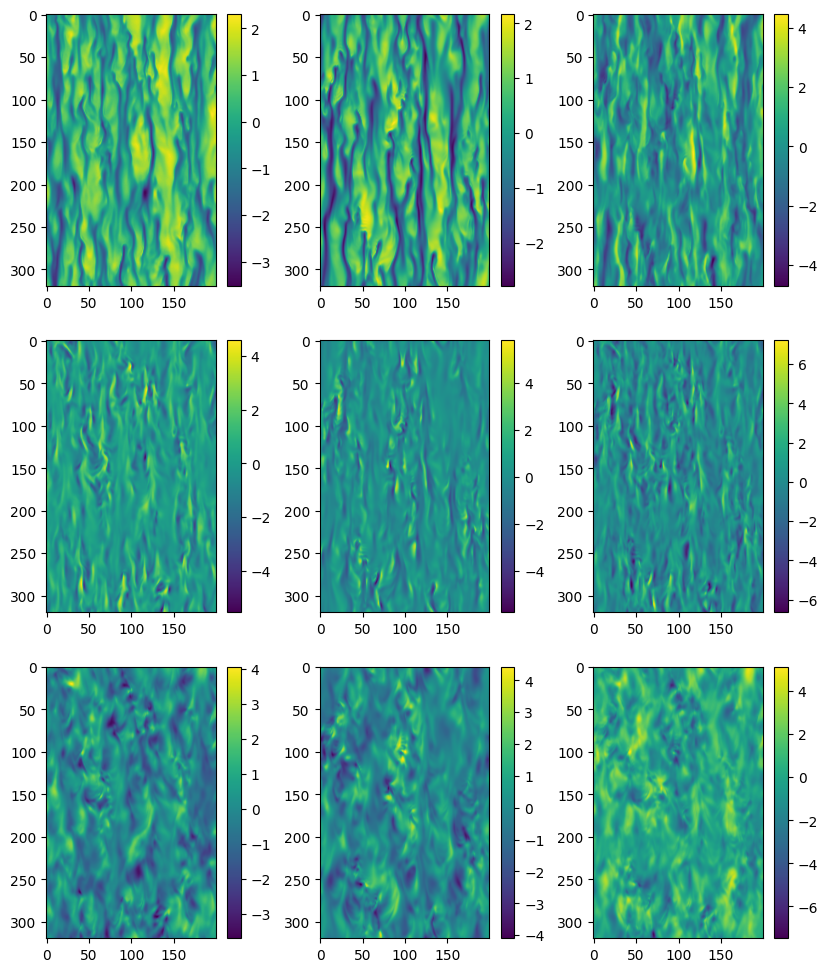

In [108]:
fig, axes= plt.subplots(nrows=3, ncols=3, figsize=(10,12))
for row in [0, 1, 2]:
    i = axes[row,0].imshow((samples)[0,row])
    fig.colorbar(i, ax=axes[row, 0])
    j = axes[row,1].imshow(X[40000, row])
    fig.colorbar(j, ax=axes[row, 1])
    k = axes[row,2].imshow(samples[0,row] -  X[40000, row])
    fig.colorbar(k, ax=axes[row, 2])
plt.show()

## Analysis (Pipeline)

In [ ]:
fig, axes= plt.subplots(nrows=3, ncols=3, figsize=(10,12))
for row in [0, 1, 2]:
    i = axes[row,0].imshow((samples)[0,row])
    fig.colorbar(i, ax=axes[row, 0])
    j = axes[row,1].imshow(X[40000, row])
    fig.colorbar(j, ax=axes[row, 1])
    k = axes[row,2].imshow(samples[0,row] -  X[10, row])
    fig.colorbar(k, ax=axes[row, 2])
plt.show()

In [ ]:
apply = lambda x: (reg_model(torch.tensor(x).to(device))).detach().cpu().numpy()

In [ ]:
samples_meas = apply(samples)
measure_x = apply(X[40000:40001])

In [ ]:
fig, axes= plt.subplots(nrows=3, ncols=4, figsize=(10,12))
for row in [0, 1, 2]:
    i = axes[row,0].imshow((samples_meas)[0,row])
    fig.colorbar(i, ax=axes[row, 0])
    j = axes[row,1].imshow(measure_x[0, row])
    fig.colorbar(j, ax=axes[row, 1])
    k = axes[row,2].imshow(np.abs(samples_meas[0,row] -  measure_x[0, row]))
    fig.colorbar(k, ax=axes[row, 2])
    l = axes[row,3].imshow((wm_data[40000, row] - meas_m[0, row].detach().cpu().numpy())/meas_std[0, row].detach().cpu().numpy())
    fig.colorbar(l, ax=axes[row, 3])
plt.show()

In [ ]:
reconst_error = (np.abs(samples_meas[0,1] -  measure_x[0, 1])[sx:ex, sy:ey]).flatten()
uncond_part_error = (np.abs(samples_meas[0,0] -  measure_x[0, 0])[sx:ex, sy:ey]).flatten()
hist = np.histogram(reconst_error, 100)
uhist = np.histogram(uncond_part_error, 100)

In [ ]:
plt.plot((hist[1][:-1] + hist[1][1:])/2, hist[0])
plt.plot((uhist[1][:-1] + uhist[1][1:])/2, uhist[0])